<a href="https://colab.research.google.com/github/Servat0r/Robotics-Project/blob/master/notebooks/DomainRandomization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd "/content/drive/MyDrive/Colab Notebooks"

/content/drive/MyDrive/Colab Notebooks


In [2]:
import numpy as np
import cv2
from PIL import Image
import os
import PIL
import tensorflow as tf
import tensorflow_datasets as tfds
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import json

In [3]:
%run utils.ipynb

/content/drive/MyDrive/Colab Notebooks


/content/drive/MyDrive/Colab Notebooks
/content/drive/MyDrive/Colab Notebooks


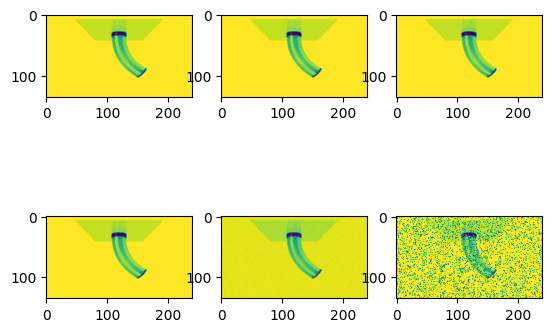

/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1176: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)


(513, 135, 240, 3) <class 'tensorflow.python.framework.ops.EagerTensor'>


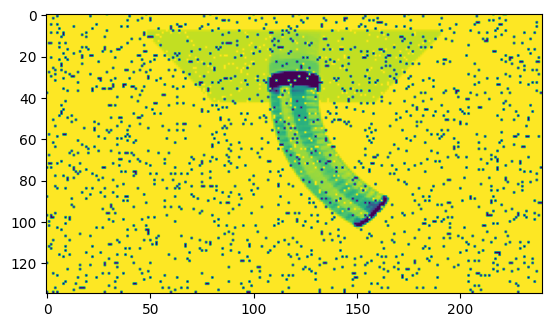

In [4]:
%run DataAugmentation.ipynb

In [5]:
batch_size = 32
resize_perc = 0.125
n_epochs = 100

## **Offline** Data Augmentation

In [6]:
augmentation_configuration = {
    'apply_brightness_change': {'delta': 0.2},
    'apply_saturation_change': {'saturation_factor': 1},
    'apply_inversion': {'prob': 0.1},
    'apply_gaussian_noise': {'sigma': 0.1},
    'apply_salt_and_pepper': {'prob': 0.1}
}

In [7]:
train_images, train_tip_pos = [], []
eval_images, eval_tip_pos = [], []
test_images, test_tip_pos = [], []
for i in range(10):
  (curr_train_images, curr_train_tip_pos), (curr_eval_images, curr_eval_tip_pos), (curr_test_images, curr_test_tip_pos) = get_augmented_dataset(
      f'data/images/{i}', target_size=(224, 224), force_resize=False,
      rescale_coordinates=100, **augmentation_configuration,
  )
  #(curr_train_images, curr_train_tip_pos), (curr_eval_images, curr_eval_tip_pos), (curr_test_images, curr_test_tip_pos) = \
  #  holdout_split(0.6, 0.2, 0.2, images, tip_pos)
  #del images, tip_pos
  train_images.append(curr_train_images)
  train_tip_pos.append(curr_train_tip_pos)
  eval_images.append(curr_eval_images)
  eval_tip_pos.append(curr_eval_tip_pos)
  test_images.append(curr_test_images)
  test_tip_pos.append(curr_test_tip_pos)

train_images = np.row_stack(train_images)
train_tip_pos = np.row_stack(train_tip_pos)
eval_images = np.row_stack(eval_images)
eval_tip_pos = np.row_stack(eval_tip_pos)
test_images = np.row_stack(test_images)
test_tip_pos = np.row_stack(test_tip_pos)

In [8]:
print(len(train_images), len(train_tip_pos), len(eval_images), len(test_images))

18420 18420 1030 1030


In [9]:
batch_size = 32  #len(images)
resize_perc = 0.125
n_epochs = 100

### VGG16 (unscaled data)

#### $10^{-3}$ learning rate

In [10]:
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
)
base_model.trainable = False

58889256/58889256 [==============================] - 4s 0us/step


In [11]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(3, activation='linear')(x)
model = tf.keras.Model(inputs, outputs)

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 3)                 75267     
                                                                 
Total params: 14,789,955
Trainable params: 75,267
Non-trainable params: 14,714,688
_________________________________________________________________


In [13]:
model.compile(
    loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=['mean_absolute_error', mean_euclidean_error]
)

In [15]:
history = model.fit(
    train_images, train_tip_pos, epochs=n_epochs,
    validation_data=(eval_images, eval_tip_pos),
    batch_size = batch_size, shuffle=True,
    callbacks=[tf.keras.callbacks.EarlyStopping(min_delta=0, patience=10)]
)

Epoch 1/100
576/576 [==============================] - 25s 28ms/step - loss: 6.5807 - mean_absolute_error: 1.4644 - mean_euclidean_error: 3.1963 - val_loss: 1.5840 - val_mean_absolute_error: 0.7833 - val_mean_euclidean_error: 1.7309
Epoch 2/100
576/576 [==============================] - 14s 25ms/step - loss: 2.3613 - mean_absolute_error: 0.8282 - mean_euclidean_error: 1.8785 - val_loss: 1.3256 - val_mean_absolute_error: 0.7281 - val_mean_euclidean_error: 1.6250
Epoch 3/100
576/576 [==============================] - 14s 25ms/step - loss: 1.7516 - mean_absolute_error: 0.6928 - mean_euclidean_error: 1.5663 - val_loss: 0.8801 - val_mean_absolute_error: 0.5595 - val_mean_euclidean_error: 1.2774
Epoch 4/100
576/576 [==============================] - 14s 25ms/step - loss: 1.4722 - mean_absolute_error: 0.6313 - mean_euclidean_error: 1.4216 - val_loss: 0.7528 - val_mean_absolute_error: 0.5340 - val_mean_euclidean_error: 1.1811
Epoch 5/100
576/576 [==============================] - 14s 25ms/step

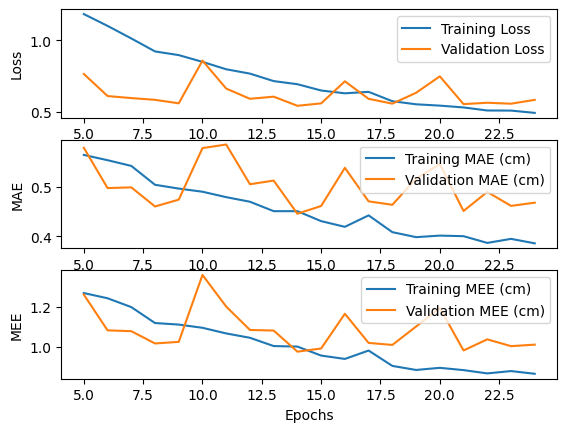

In [18]:
plot_metrics(
    history, start_epoch=5, end_epoch=None,
    metrics=['loss', 'mean_absolute_error', 'mean_euclidean_error'],
    data_labels=[
        ('Training Loss', 'Validation Loss'), ('Training MAE (cm)', 'Validation MAE (cm)'),
        ('Training MEE (cm)', 'Validation MEE (cm)')
    ],
    axes_labels=[
        ('Epochs', 'Loss'), ('Epochs', 'MAE'), ('Epochs', 'MEE')
    ]
)

33/33 [==============================] - 1s 21ms/step
1030 1030 1030
1030 1030 1030
x-axis: mean = 0.6608690132520021, std = 3.245098608512179
y-axis: mean = 0.13770818194397721, std = 0.6909831228427316
z-axis: mean = 0.01638310842938852, std = 0.017892272654099175


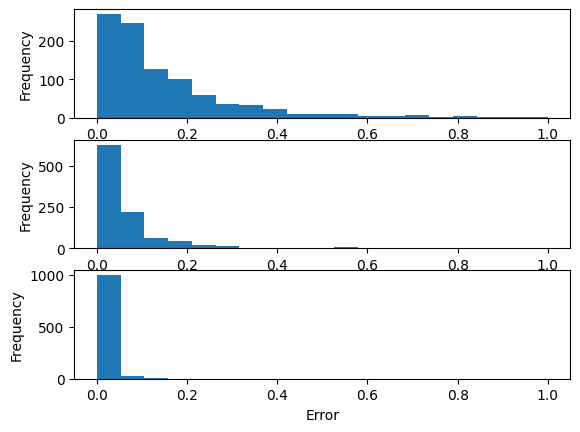

In [19]:
epsilon = 1e-12
predictions = model.predict(eval_images)
plot_relative_errors(predictions, eval_tip_pos, epsilon, max_error=1, nbins=20)

...

We now calculate also mean and standard deviation of loss, absolute and euclidean errors:

In [20]:
mean_absolute_errors = tf.keras.metrics.mean_absolute_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MAE: {np.mean(mean_absolute_errors)}')
print(f'Std of MAE: {np.std(mean_absolute_errors)}')

mean_euclidean_errors = mean_euclidean_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MEE: {np.mean(mean_euclidean_errors)}')
print(f'Std of MEE: {np.std(mean_euclidean_errors)}')

Mean of MAE: 0.4683994650840759
Std of MAE: 0.35393962264060974
Mean of MEE: 1.010863975144859
Std of MEE: 0.856029450245616


We calculate them also along each axis:

In [21]:
distances = np.abs(eval_tip_pos - predictions)
print(f'Mean Distance along axes: {np.mean(distances, axis=0)}')
print(f'Std of Distance along axes: {np.std(distances, axis=0)}')

Mean Distance along axes: [0.82747901 0.30188477 0.27583458]
Std of Distance along axes: [0.88092368 0.27877127 0.22125052]


In [22]:
del model, base_model, history

#### $5\cdot10^{-4}$ learning rate

In [23]:
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
)
base_model.trainable = False

In [24]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(3, activation='linear')(x)
model = tf.keras.Model(inputs, outputs)

In [25]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 3)                 75267     
                                                                 
Total params: 14,789,955
Trainable params: 75,267
Non-trainable params: 14,714,688
_________________________________________________________________


In [26]:
model.compile(
    loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    metrics=['mean_absolute_error', mean_euclidean_error]
)

In [27]:
history = model.fit(
    train_images, train_tip_pos, epochs=n_epochs,
    validation_data=(eval_images, eval_tip_pos),
    batch_size = batch_size, shuffle=True,
    callbacks=[tf.keras.callbacks.EarlyStopping(min_delta=0, patience=15)]
)

Epoch 1/100
576/576 [==============================] - 16s 26ms/step - loss: 8.9880 - mean_absolute_error: 1.8026 - mean_euclidean_error: 3.8883 - val_loss: 2.5539 - val_mean_absolute_error: 0.9664 - val_mean_euclidean_error: 2.1647
Epoch 2/100
576/576 [==============================] - 14s 25ms/step - loss: 3.0526 - mean_absolute_error: 0.9604 - mean_euclidean_error: 2.1658 - val_loss: 1.4838 - val_mean_absolute_error: 0.7438 - val_mean_euclidean_error: 1.6594
Epoch 3/100
576/576 [==============================] - 14s 25ms/step - loss: 2.3213 - mean_absolute_error: 0.8003 - mean_euclidean_error: 1.8216 - val_loss: 1.3325 - val_mean_absolute_error: 0.7132 - val_mean_euclidean_error: 1.6212
Epoch 4/100
576/576 [==============================] - 14s 25ms/step - loss: 1.9080 - mean_absolute_error: 0.7102 - mean_euclidean_error: 1.6168 - val_loss: 0.9593 - val_mean_absolute_error: 0.5964 - val_mean_euclidean_error: 1.3385
Epoch 5/100
576/576 [==============================] - 14s 25ms/step

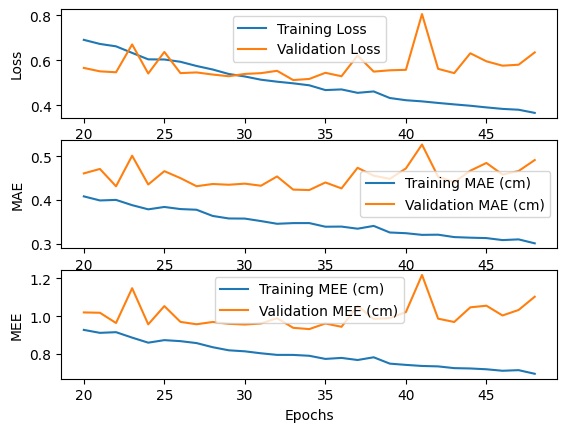

In [28]:
plot_metrics(
    history, start_epoch=20, end_epoch=None,
    metrics=['loss', 'mean_absolute_error', 'mean_euclidean_error'],
    data_labels=[
        ('Training Loss', 'Validation Loss'), ('Training MAE (cm)', 'Validation MAE (cm)'),
        ('Training MEE (cm)', 'Validation MEE (cm)')
    ],
    axes_labels=[
        ('Epochs', 'Loss'), ('Epochs', 'MAE'), ('Epochs', 'MEE')
    ]
)

33/33 [==============================] - 1s 21ms/step
1030 1030 1030
1030 1030 1030
x-axis: mean = 0.8586362219710928, std = 4.07879429170958
y-axis: mean = 0.13443741340040768, std = 0.6326234457969809
z-axis: mean = 0.013532555794128013, std = 0.017477267621455208


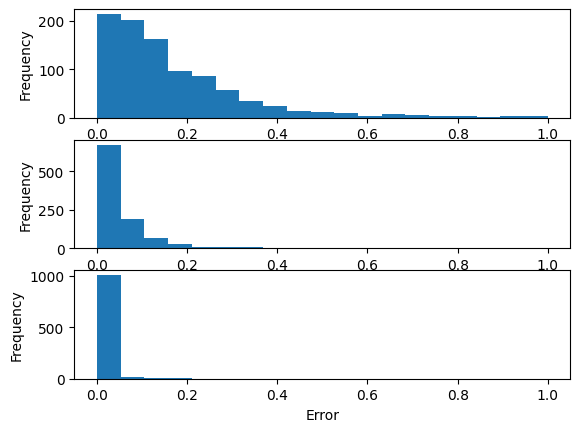

In [29]:
epsilon = 1e-12
predictions = model.predict(eval_images)
plot_relative_errors(predictions, eval_tip_pos, epsilon, max_error=1, nbins=20)

...

We now calculate also mean and standard deviation of loss, absolute and euclidean errors:

In [30]:
mean_absolute_errors = tf.keras.metrics.mean_absolute_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MAE: {np.mean(mean_absolute_errors)}')
print(f'Std of MAE: {np.std(mean_absolute_errors)}')

mean_euclidean_errors = mean_euclidean_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MEE: {np.mean(mean_euclidean_errors)}')
print(f'Std of MEE: {np.std(mean_euclidean_errors)}')

Mean of MAE: 0.49158772826194763
Std of MAE: 0.34432777762413025
Mean of MEE: 1.1034040116392174
Std of MEE: 0.8297790947020274


We calculate them also along each axis:

In [31]:
distances = np.abs(eval_tip_pos - predictions)
print(f'Mean Distance along axes: {np.mean(distances, axis=0)}')
print(f'Std of Distance along axes: {np.std(distances, axis=0)}')

Mean Distance along axes: [0.96943739 0.28008805 0.2252377 ]
Std of Distance along axes: [0.8472273  0.2702226  0.21500977]


In [32]:
del model

In [33]:
del base_model. history

#### $10^{-4}$ learning rate

In [34]:
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
)
base_model.trainable = False

In [35]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(3, activation='linear')(x)
model = tf.keras.Model(inputs, outputs)

In [36]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 3)                 75267     
                                                                 
Total params: 14,789,955
Trainable params: 75,267
Non-trainable params: 14,714,688
_________________________________________________________________


In [37]:
model.compile(
    loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['mean_absolute_error', mean_euclidean_error]
)

In [38]:
history = model.fit(
    train_images, train_tip_pos, epochs=n_epochs,
    validation_data=(eval_images, eval_tip_pos),
    batch_size = batch_size, shuffle=True,
    callbacks=[tf.keras.callbacks.EarlyStopping(min_delta=0, patience=15)]
)

Epoch 1/100
576/576 [==============================] - 16s 26ms/step - loss: 21.8787 - mean_absolute_error: 3.2774 - mean_euclidean_error: 6.9347 - val_loss: 8.8714 - val_mean_absolute_error: 2.0332 - val_mean_euclidean_error: 4.4841
Epoch 2/100
576/576 [==============================] - 14s 25ms/step - loss: 7.0701 - mean_absolute_error: 1.7072 - mean_euclidean_error: 3.7449 - val_loss: 4.7250 - val_mean_absolute_error: 1.3835 - val_mean_euclidean_error: 3.0779
Epoch 3/100
576/576 [==============================] - 14s 25ms/step - loss: 4.8808 - mean_absolute_error: 1.3197 - mean_euclidean_error: 2.9336 - val_loss: 3.4802 - val_mean_absolute_error: 1.1519 - val_mean_euclidean_error: 2.5828
Epoch 4/100
576/576 [==============================] - 14s 25ms/step - loss: 3.9826 - mean_absolute_error: 1.1407 - mean_euclidean_error: 2.5594 - val_loss: 2.6094 - val_mean_absolute_error: 0.9756 - val_mean_euclidean_error: 2.1882
Epoch 5/100
576/576 [==============================] - 14s 25ms/ste

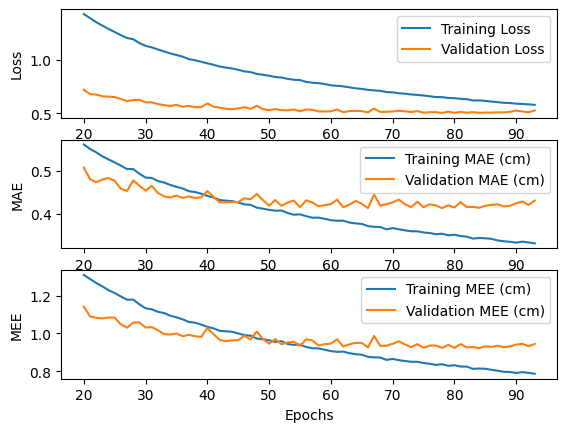

In [39]:
plot_metrics(
    history, start_epoch=20, end_epoch=None,
    metrics=['loss', 'mean_absolute_error', 'mean_euclidean_error'],
    data_labels=[
        ('Training Loss', 'Validation Loss'), ('Training MAE (cm)', 'Validation MAE (cm)'),
        ('Training MEE (cm)', 'Validation MEE (cm)')
    ],
    axes_labels=[
        ('Epochs', 'Loss'), ('Epochs', 'MAE'), ('Epochs', 'MEE')
    ]
)

33/33 [==============================] - 1s 21ms/step
1030 1030 1030
1030 1030 1030
x-axis: mean = 0.6457572569951743, std = 3.163036268786901
y-axis: mean = 0.15033097759197733, std = 0.7997558931922926
z-axis: mean = 0.013003555097401824, std = 0.01775282459317282


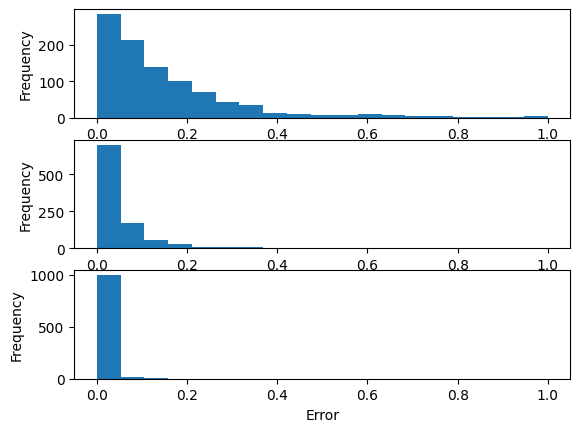

In [40]:
epsilon = 1e-12
predictions = model.predict(eval_images)
plot_relative_errors(predictions, eval_tip_pos, epsilon, max_error=1, nbins=20)

...

We now calculate also mean and standard deviation of loss, absolute and euclidean errors:

In [41]:
mean_absolute_errors = tf.keras.metrics.mean_absolute_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MAE: {np.mean(mean_absolute_errors)}')
print(f'Std of MAE: {np.std(mean_absolute_errors)}')

mean_euclidean_errors = mean_euclidean_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MEE: {np.mean(mean_euclidean_errors)}')
print(f'Std of MEE: {np.std(mean_euclidean_errors)}')

Mean of MAE: 0.4306755065917969
Std of MAE: 0.34101948142051697
Mean of MEE: 0.944412446118011
Std of MEE: 0.8284150195136102


We calculate them also along each axis:

In [42]:
distances = np.abs(eval_tip_pos - predictions)
print(f'Mean Distance along axes: {np.mean(distances, axis=0)}')
print(f'Std of Distance along axes: {np.std(distances, axis=0)}')

Mean Distance along axes: [0.80272929 0.2776652  0.21163198]
Std of Distance along axes: [0.83782567 0.26047232 0.20525167]


In [43]:
model.save('finetunedVGG16OfflineDataAugmentation5130Dataset')

In [45]:
json.dump(history.history, open('finetunedVGG16OfflineDataAugmentation5130Dataset.json', 'w'))

In [46]:
del model

### VGG16 - scaled data

#### $5\cdot10^{-4}$ learning rate

In [10]:
train_mean, train_std = np.mean(train_tip_pos), np.mean(eval_tip_pos)
train_tip_pos_bak = train_tip_pos.copy()
train_tip_pos = (train_tip_pos - train_mean) / train_std
eval_tip_pos = (eval_tip_pos - train_mean) / (train_std)

In [11]:
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
)
base_model.trainable = False

58889256/58889256 [==============================] - 4s 0us/step


In [12]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(3, activation='linear')(x)
model = tf.keras.Model(inputs, outputs)

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 3)                 75267     
                                                                 
Total params: 14,789,955
Trainable params: 75,267
Non-trainable params: 14,714,688
_________________________________________________________________


In [14]:
model.compile(
    loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    metrics=['mean_absolute_error', mean_euclidean_error]
)

In [15]:
history = model.fit(
    train_images, train_tip_pos, epochs=n_epochs,
    validation_data=(eval_images, eval_tip_pos),
    batch_size = batch_size, shuffle=True,
    callbacks=[tf.keras.callbacks.EarlyStopping(min_delta=0, patience=15)]
)

Epoch 1/100
576/576 [==============================] - 25s 28ms/step - loss: 0.1466 - mean_absolute_error: 0.2173 - mean_euclidean_error: 0.4657 - val_loss: 0.0319 - val_mean_absolute_error: 0.1229 - val_mean_euclidean_error: 0.2608
Epoch 2/100
576/576 [==============================] - 14s 25ms/step - loss: 0.0526 - mean_absolute_error: 0.1367 - mean_euclidean_error: 0.2955 - val_loss: 0.0224 - val_mean_absolute_error: 0.0987 - val_mean_euclidean_error: 0.2118
Epoch 3/100
576/576 [==============================] - 14s 25ms/step - loss: 0.0410 - mean_absolute_error: 0.1215 - mean_euclidean_error: 0.2598 - val_loss: 0.0272 - val_mean_absolute_error: 0.1209 - val_mean_euclidean_error: 0.2497
Epoch 4/100
576/576 [==============================] - 14s 25ms/step - loss: 0.0377 - mean_absolute_error: 0.1207 - mean_euclidean_error: 0.2574 - val_loss: 0.0298 - val_mean_absolute_error: 0.1346 - val_mean_euclidean_error: 0.2641
Epoch 5/100
576/576 [==============================] - 14s 25ms/step

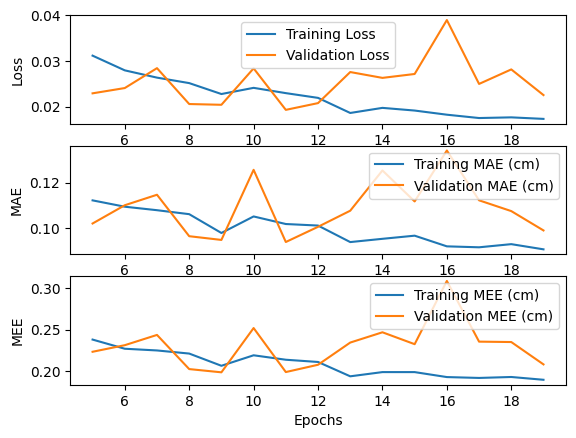

In [17]:
plot_metrics(
    history, start_epoch=5, end_epoch=None,
    metrics=['loss', 'mean_absolute_error', 'mean_euclidean_error'],
    data_labels=[
        ('Training Loss', 'Validation Loss'), ('Training MAE (cm)', 'Validation MAE (cm)'),
        ('Training MEE (cm)', 'Validation MEE (cm)')
    ],
    axes_labels=[
        ('Epochs', 'Loss'), ('Epochs', 'MAE'), ('Epochs', 'MEE')
    ]
)

33/33 [==============================] - 1s 21ms/step
1030 1030 1030
1030 1030 1030
x-axis: mean = 0.4602321915214002, std = 1.905571734592912
y-axis: mean = 0.1758912675992481, std = 0.4279792683547519
z-axis: mean = 0.03842941202683134, std = 0.05823632348638531


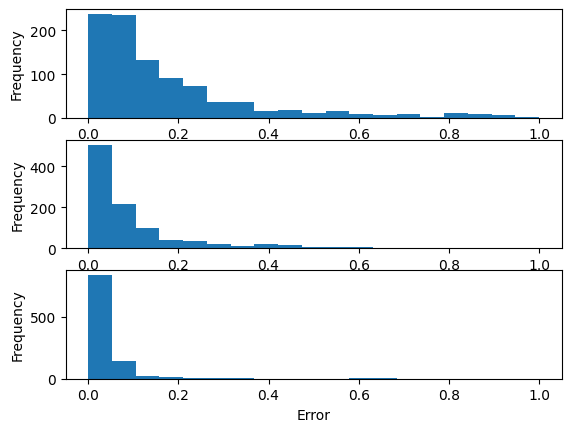

In [18]:
epsilon = 1e-12
predictions = model.predict(eval_images)
plot_relative_errors(predictions, eval_tip_pos, epsilon, max_error=1, nbins=20)

...

We now calculate also mean and standard deviation of loss, absolute and euclidean errors:

In [19]:
mean_absolute_errors = tf.keras.metrics.mean_absolute_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MAE: {np.mean(mean_absolute_errors)}')
print(f'Std of MAE: {np.std(mean_absolute_errors)}')

mean_euclidean_errors = mean_euclidean_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MEE: {np.mean(mean_euclidean_errors)}')
print(f'Std of MEE: {np.std(mean_euclidean_errors)}')

Mean of MAE: 0.0989355817437172
Std of MAE: 0.06538711488246918
Mean of MEE: 0.20840189996978925
Std of MEE: 0.15527204827407473


We calculate them also along each axis:

In [20]:
distances = np.abs(eval_tip_pos - predictions)
print(f'Mean Distance along axes: {np.mean(distances, axis=0)}')
print(f'Std of Distance along axes: {np.std(distances, axis=0)}')

Mean Distance along axes: [0.1560008  0.08051444 0.06029149]
Std of Distance along axes: [0.16389127 0.06142417 0.04953376]


In [21]:
history = model.fit(
    train_images, train_tip_pos, epochs=80,
    validation_data=(eval_images, eval_tip_pos),
    batch_size = batch_size, shuffle=True,
    callbacks=[tf.keras.callbacks.EarlyStopping(min_delta=0, patience=15)]
)

Epoch 1/80
576/576 [==============================] - 15s 26ms/step - loss: 0.0151 - mean_absolute_error: 0.0840 - mean_euclidean_error: 0.1762 - val_loss: 0.0331 - val_mean_absolute_error: 0.1231 - val_mean_euclidean_error: 0.2652
Epoch 2/80
576/576 [==============================] - 14s 25ms/step - loss: 0.0154 - mean_absolute_error: 0.0892 - mean_euclidean_error: 0.1829 - val_loss: 0.0183 - val_mean_absolute_error: 0.0862 - val_mean_euclidean_error: 0.1867
Epoch 3/80
576/576 [==============================] - 14s 25ms/step - loss: 0.0151 - mean_absolute_error: 0.0885 - mean_euclidean_error: 0.1825 - val_loss: 0.0229 - val_mean_absolute_error: 0.1061 - val_mean_euclidean_error: 0.2201
Epoch 4/80
576/576 [==============================] - 14s 25ms/step - loss: 0.0164 - mean_absolute_error: 0.0912 - mean_euclidean_error: 0.1896 - val_loss: 0.0198 - val_mean_absolute_error: 0.0917 - val_mean_euclidean_error: 0.1966
Epoch 5/80
576/576 [==============================] - 14s 25ms/step - lo

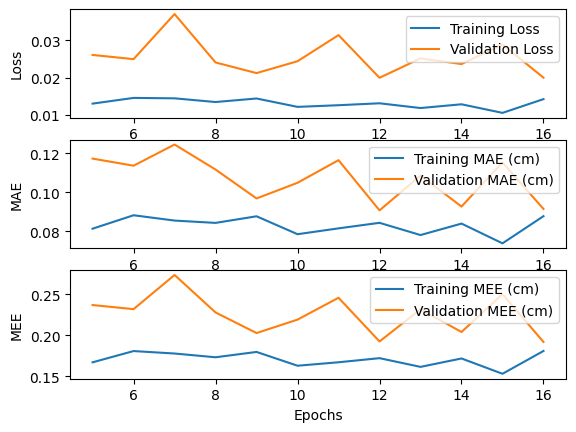

In [22]:
plot_metrics(
    history, start_epoch=5, end_epoch=None,
    metrics=['loss', 'mean_absolute_error', 'mean_euclidean_error'],
    data_labels=[
        ('Training Loss', 'Validation Loss'), ('Training MAE (cm)', 'Validation MAE (cm)'),
        ('Training MEE (cm)', 'Validation MEE (cm)')
    ],
    axes_labels=[
        ('Epochs', 'Loss'), ('Epochs', 'MAE'), ('Epochs', 'MEE')
    ]
)

33/33 [==============================] - 1s 21ms/step
1030 1030 1030
1030 1030 1030
x-axis: mean = 0.37015317476193216, std = 1.5650821902564949
y-axis: mean = 0.13952320062719673, std = 0.38193461599832523
z-axis: mean = 0.04186785229109174, std = 0.056297656005193354


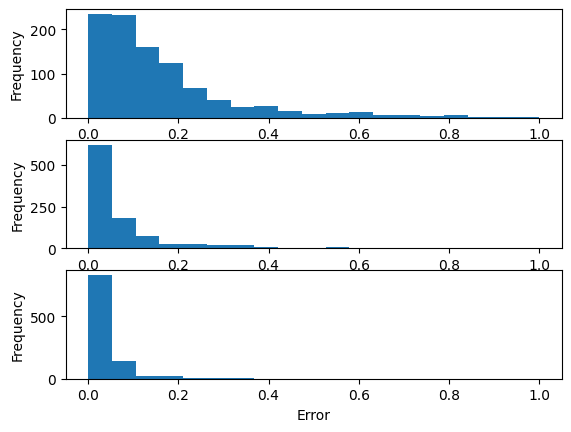

In [23]:
epsilon = 1e-12
predictions = model.predict(eval_images)
plot_relative_errors(predictions, eval_tip_pos, epsilon, max_error=1, nbins=20)

...

We now calculate also mean and standard deviation of loss, absolute and euclidean errors:

In [24]:
mean_absolute_errors = tf.keras.metrics.mean_absolute_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MAE: {np.mean(mean_absolute_errors)}')
print(f'Std of MAE: {np.std(mean_absolute_errors)}')

mean_euclidean_errors = mean_euclidean_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MEE: {np.mean(mean_euclidean_errors)}')
print(f'Std of MEE: {np.std(mean_euclidean_errors)}')

Mean of MAE: 0.09144746512174606
Std of MAE: 0.06607204675674438
Mean of MEE: 0.19196759865876975
Std of MEE: 0.15188628054408962


We calculate them also along each axis:

In [25]:
distances = np.abs(eval_tip_pos - predictions)
print(f'Mean Distance along axes: {np.mean(distances, axis=0)}')
print(f'Std of Distance along axes: {np.std(distances, axis=0)}')

Mean Distance along axes: [0.14661868 0.06094855 0.06677515]
Std of Distance along axes: [0.15715148 0.05657058 0.04851289]


In [26]:
del model

In [27]:
del base_model. history

In [28]:
del train_images, train_tip_pos, eval_images, eval_tip_pos, test_images, test_tip_pos

## **Online** Data Augmentation

In [44]:
train_images, train_tip_pos = [], []
eval_images, eval_tip_pos = [], []
test_images, test_tip_pos = [], []
for i in range(10):
  images, tip_pos = get_dataset(
      f'data/images/{i}', target_size=(224, 224), force_resize=False, rescale_coordinates=100
  )
  (curr_train_images, curr_train_tip_pos), (curr_eval_images, curr_eval_tip_pos), (curr_test_images, curr_test_tip_pos) = \
    holdout_split(0.6, 0.2, 0.2, images, tip_pos)
  del images, tip_pos
  train_images.append(curr_train_images)
  train_tip_pos.append(curr_train_tip_pos)
  eval_images.append(curr_eval_images)
  eval_tip_pos.append(curr_eval_tip_pos)
  test_images.append(curr_test_images)
  test_tip_pos.append(curr_test_tip_pos)

train_images = np.row_stack(train_images)
train_tip_pos = np.row_stack(train_tip_pos)
eval_images = np.row_stack(eval_images)
eval_tip_pos = np.row_stack(eval_tip_pos)
test_images = np.row_stack(test_images)
test_tip_pos = np.row_stack(test_tip_pos)

In [30]:
online_augmentation_configuration = {
    'apply_brightness_change': {'factor': 0.1},
    'apply_saturation_change': {'factor': 1},
    'apply_inversion': {'prob': 0.1},
    'apply_gaussian_noise': {'stddev': 0.1},
    'apply_salt_and_pepper': {'ratio': 0.1}
}
data_augmenter = get_data_augmentation_layer(**online_augmentation_configuration)

### VGG16 (unscaled data)

#### $10^{-3}$ learning rate

In [8]:
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
)
base_model.trainable = False

In [9]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = data_augmenter(inputs, training=False)
x = base_model(x, training=False)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(3, activation='linear')(x)
model = tf.keras.Model(inputs, outputs)

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 3)                 75267     
                                                                 
Total params: 14,789,955
Trainable params: 75,267
Non-trainable params: 14,714,688
_________________________________________________________________


In [11]:
model.compile(
    loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=['mean_absolute_error', mean_euclidean_error],
)

In [12]:
history = model.fit(
    train_images, train_tip_pos, epochs=n_epochs,
    validation_data=(eval_images, eval_tip_pos),
    batch_size = batch_size, shuffle=True,
    callbacks=tf.keras.callbacks.EarlyStopping(min_delta=0, patience=15)
)

Epoch 1/100
96/96 [==============================] - 24s 110ms/step - loss: 18.7523 - mean_absolute_error: 2.9423 - mean_euclidean_error: 6.1424 - val_loss: 7.1056 - val_mean_absolute_error: 1.8245 - val_mean_euclidean_error: 3.9820
Epoch 2/100
96/96 [==============================] - 7s 75ms/step - loss: 4.0205 - mean_absolute_error: 1.3136 - mean_euclidean_error: 2.9051 - val_loss: 5.0763 - val_mean_absolute_error: 1.4595 - val_mean_euclidean_error: 3.2715
Epoch 3/100
96/96 [==============================] - 6s 63ms/step - loss: 2.5644 - mean_absolute_error: 1.0184 - mean_euclidean_error: 2.2675 - val_loss: 3.0911 - val_mean_absolute_error: 1.1281 - val_mean_euclidean_error: 2.4846
Epoch 4/100
96/96 [==============================] - 6s 65ms/step - loss: 1.9750 - mean_absolute_error: 0.8982 - mean_euclidean_error: 2.0021 - val_loss: 2.7050 - val_mean_absolute_error: 1.0132 - val_mean_euclidean_error: 2.2717
Epoch 5/100
96/96 [==============================] - 7s 74ms/step - loss: 1.7

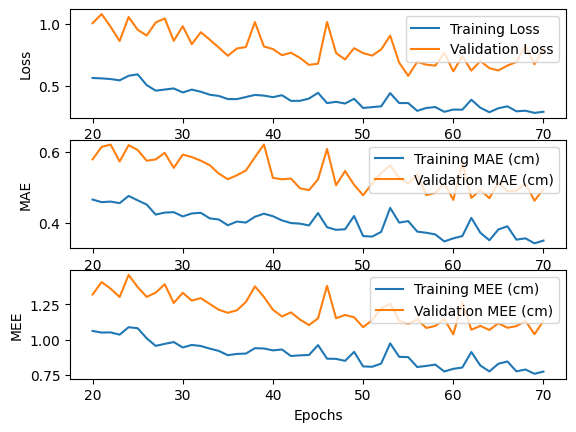

In [13]:
plot_metrics(
    history, start_epoch=20, end_epoch=None,
    metrics=['loss', 'mean_absolute_error', 'mean_euclidean_error'],
    data_labels=[
        ('Training Loss', 'Validation Loss'), ('Training MAE (cm)', 'Validation MAE (cm)'),
        ('Training MEE (cm)', 'Validation MEE (cm)')
    ],
    axes_labels=[
        ('Epochs', 'Loss'), ('Epochs', 'MAE'), ('Epochs', 'MEE')
    ]
)

33/33 [==============================] - 2s 44ms/step
1030 1030 1030
1030 1030 1030
x-axis: mean = 0.6481312835032962, std = 3.4722837113149145
y-axis: mean = 0.18741019976407067, std = 1.1389454068752918
z-axis: mean = 0.01326533266482813, std = 0.019509562800331077


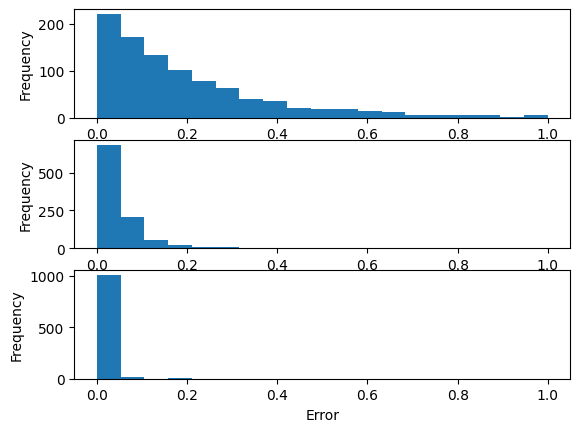

In [14]:
epsilon = 1e-12
predictions = model.predict(eval_images)
plot_relative_errors(predictions, eval_tip_pos, epsilon, max_error=1, nbins=20)

...

We now calculate also mean and standard deviation of loss, absolute and euclidean errors:

In [15]:
mean_absolute_errors = tf.keras.metrics.mean_absolute_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MAE: {np.mean(mean_absolute_errors)}')
print(f'Std of MAE: {np.std(mean_absolute_errors)}')

mean_euclidean_errors = mean_euclidean_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MEE: {np.mean(mean_euclidean_errors)}')
print(f'Std of MEE: {np.std(mean_euclidean_errors)}')

Mean of MAE: 0.49568048119544983
Std of MAE: 0.33599168062210083
Mean of MEE: 1.1336189320370345
Std of MEE: 0.8393414124320683


We calculate them also along each axis:

In [16]:
distances = np.abs(eval_tip_pos - predictions)
print(f'Mean Distance along axes: {np.mean(distances, axis=0)}')
print(f'Std of Distance along axes: {np.std(distances, axis=0)}')

Mean Distance along axes: [1.00387131 0.26888455 0.21428557]
Std of Distance along axes: [0.87094518 0.24373883 0.21367487]


In [17]:
del model

In [18]:
del history, distances, mean_absolute_errors, mean_euclidean_errors

In [20]:
del base_model

#### $5\cdot10^{-4}$ learning rate

In [21]:
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
)
base_model.trainable = False

In [22]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = data_augmenter(inputs, training=False)
x = base_model(x, training=False)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(3, activation='linear')(x)
model = tf.keras.Model(inputs, outputs)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1176: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)


In [23]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 3)                 75267     
                                                                 
Total params: 14,789,955
Trainable params: 75,267
Non-trainable params: 14,714,688
_________________________________________________________________


In [24]:
model.compile(
    loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    metrics=['mean_absolute_error', mean_euclidean_error]
)

In [25]:
history = model.fit(
    train_images, train_tip_pos, epochs=n_epochs,
    validation_data=(eval_images, eval_tip_pos),
    batch_size = batch_size, shuffle=True,
)

Epoch 1/100
96/96 [==============================] - 10s 91ms/step - loss: 25.1516 - mean_absolute_error: 3.5655 - mean_euclidean_error: 7.4285 - val_loss: 12.8135 - val_mean_absolute_error: 2.4976 - val_mean_euclidean_error: 5.4467
Epoch 2/100
96/96 [==============================] - 7s 75ms/step - loss: 6.9274 - mean_absolute_error: 1.7664 - mean_euclidean_error: 3.8963 - val_loss: 6.8520 - val_mean_absolute_error: 1.7640 - val_mean_euclidean_error: 3.8815
Epoch 3/100
96/96 [==============================] - 6s 64ms/step - loss: 4.1156 - mean_absolute_error: 1.3299 - mean_euclidean_error: 2.9443 - val_loss: 4.7871 - val_mean_absolute_error: 1.4563 - val_mean_euclidean_error: 3.1913
Epoch 4/100
96/96 [==============================] - 7s 74ms/step - loss: 3.1605 - mean_absolute_error: 1.1497 - mean_euclidean_error: 2.5479 - val_loss: 4.1632 - val_mean_absolute_error: 1.3070 - val_mean_euclidean_error: 2.9127
Epoch 5/100
96/96 [==============================] - 6s 64ms/step - loss: 2.6

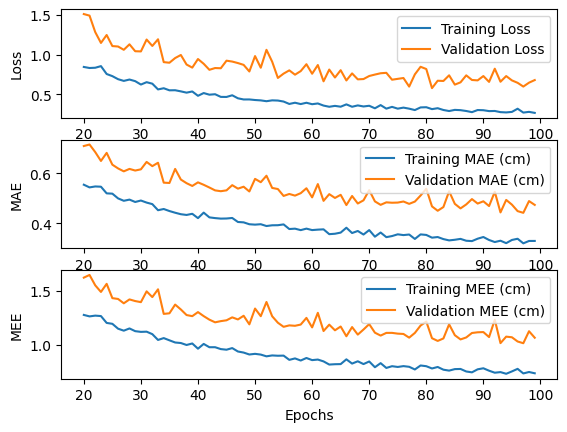

In [26]:
plot_metrics(
    history, start_epoch=20, end_epoch=None,
    metrics=['loss', 'mean_absolute_error', 'mean_euclidean_error'],
    data_labels=[
        ('Training Loss', 'Validation Loss'), ('Training MAE (cm)', 'Validation MAE (cm)'),
        ('Training MEE (cm)', 'Validation MEE (cm)')
    ],
    axes_labels=[
        ('Epochs', 'Loss'), ('Epochs', 'MAE'), ('Epochs', 'MEE')
    ]
)

33/33 [==============================] - 2s 46ms/step
1030 1030 1030
1030 1030 1030
x-axis: mean = 0.7003948528281579, std = 3.5274179654511126
y-axis: mean = 0.1748749360776184, std = 0.8937178233483958
z-axis: mean = 0.011286673621708564, std = 0.014433512155447324


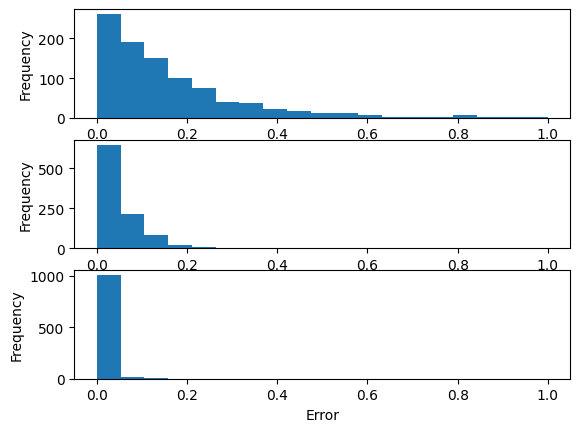

In [27]:
epsilon = 1e-12
predictions = model.predict(eval_images)
plot_relative_errors(predictions, eval_tip_pos, epsilon, max_error=1, nbins=20)

...

We now calculate also mean and standard deviation of loss, absolute and euclidean errors:

In [28]:
mean_absolute_errors = tf.keras.metrics.mean_absolute_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MAE: {np.mean(mean_absolute_errors)}')
print(f'Std of MAE: {np.std(mean_absolute_errors)}')

mean_euclidean_errors = mean_euclidean_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MEE: {np.mean(mean_euclidean_errors)}')
print(f'Std of MEE: {np.std(mean_euclidean_errors)}')

Mean of MAE: 0.4576627314090729
Std of MAE: 0.34632617235183716
Mean of MEE: 1.0287066485896437
Std of MEE: 0.8656039757403108


We calculate them also along each axis:

In [29]:
distances = np.abs(eval_tip_pos - predictions)
print(f'Mean Distance along axes: {np.mean(distances, axis=0)}')
print(f'Std of Distance along axes: {np.std(distances, axis=0)}')

Mean Distance along axes: [0.88310169 0.30399006 0.18589644]
Std of Distance along axes: [0.89353915 0.26699798 0.17598705]


In [ ]:
del model

#### $10^{-4}$ learning rate

In [6]:
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
)
base_model.trainable = False

In [7]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = data_augmenter(inputs, training=False)
x = base_model(x, training=False)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(3, activation='linear')(x)
model = tf.keras.Model(inputs, outputs)

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 3)                 75267     
                                                                 
Total params: 14,789,955
Trainable params: 75,267
Non-trainable params: 14,714,688
_________________________________________________________________


In [11]:
model.compile(
    loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['mean_absolute_error', mean_euclidean_error]
)

In [12]:
history = model.fit(
    train_images, train_tip_pos, epochs=n_epochs,
    validation_data=(eval_images, eval_tip_pos),
    batch_size = batch_size, shuffle=True,
    callbacks=[tf.keras.callbacks.EarlyStopping(min_delta=0, patience=15)]
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1176: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)


96/96 [==============================] - 24s 130ms/step - loss: 58.0990 - mean_absolute_error: 6.0901 - mean_euclidean_error: 12.4071 - val_loss: 30.7604 - val_mean_absolute_error: 4.5460 - val_mean_euclidean_error: 9.1035
Epoch 2/100
96/96 [==============================] - 8s 80ms/step - loss: 21.2731 - mean_absolute_error: 3.5509 - mean_euclidean_error: 7.4449 - val_loss: 21.2196 - val_mean_absolute_error: 3.6105 - val_mean_euclidean_error: 7.4167
Epoch 3/100
96/96 [==============================] - 7s 77ms/step - loss: 15.0759 - mean_absolute_error: 2.8303 - mean_euclidean_error: 6.1088 - val_loss: 16.5686 - val_mean_absolute_error: 3.0340 - val_mean_euclidean_error: 6.4017
Epoch 4/100
96/96 [==============================] - 7s 74ms/step - loss: 11.8069 - mean_absolute_error: 2.4178 - mean_euclidean_error: 5.2993 - val_loss: 13.2902 - val_mean_absolute_error: 2.6368 - val_mean_euclidean_error: 5.6766
Epoch 5/100
96/96 [==============================] - 7s 77ms/step - loss: 9.7586 

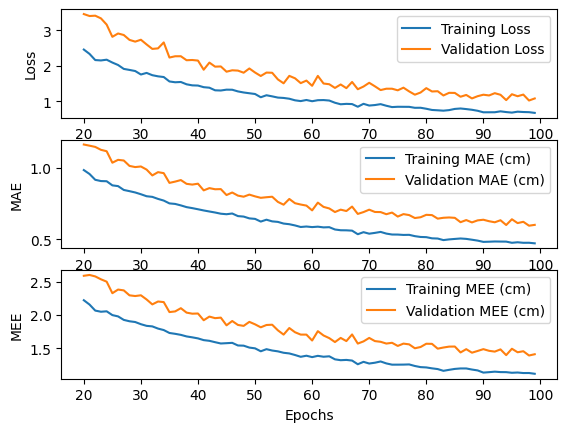

In [13]:
plot_metrics(
    history, start_epoch=20, end_epoch=None,
    metrics=['loss', 'mean_absolute_error', 'mean_euclidean_error'],
    data_labels=[
        ('Training Loss', 'Validation Loss'), ('Training MAE (cm)', 'Validation MAE (cm)'),
        ('Training MEE (cm)', 'Validation MEE (cm)')
    ],
    axes_labels=[
        ('Epochs', 'Loss'), ('Epochs', 'MAE'), ('Epochs', 'MEE')
    ]
)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1176: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)


33/33 [==============================] - 2s 45ms/step
1030 1030 1030
1030 1030 1030
x-axis: mean = 1.060220607326181, std = 5.052346378164607
y-axis: mean = 0.1008823952450588, std = 0.3675077866710672
z-axis: mean = 0.013503117412109295, std = 0.017202023662239708


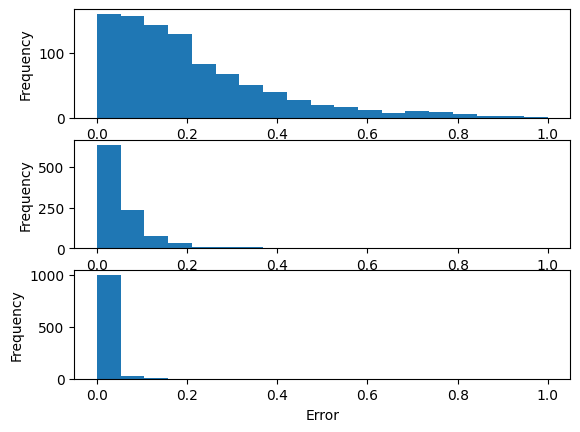

In [14]:
epsilon = 1e-12
predictions = model.predict(eval_images)
plot_relative_errors(predictions, eval_tip_pos, epsilon, max_error=1, nbins=20)

...

We now calculate also mean and standard deviation of loss, absolute and euclidean errors:

In [15]:
mean_absolute_errors = tf.keras.metrics.mean_absolute_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MAE: {np.mean(mean_absolute_errors)}')
print(f'Std of MAE: {np.std(mean_absolute_errors)}')

mean_euclidean_errors = mean_euclidean_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MEE: {np.mean(mean_euclidean_errors)}')
print(f'Std of MEE: {np.std(mean_euclidean_errors)}')

Mean of MAE: 0.6058270931243896
Std of MAE: 0.45388275384902954
Mean of MEE: 1.4156077142936792
Std of MEE: 1.1384112248524556


We calculate them also along each axis:

In [16]:
distances = np.abs(eval_tip_pos - predictions)
print(f'Mean Distance along axes: {np.mean(distances, axis=0)}')
print(f'Std of Distance along axes: {np.std(distances, axis=0)}')

Mean Distance along axes: [1.29441126 0.29845644 0.22461347]
Std of Distance along axes: [1.16121939 0.30144027 0.2135431 ]


In [ ]:
del model

In [ ]:
del base_model, history

### VGG16 (scaled data)

#### $5\cdot10^{-4}$ learning rate

In [32]:
train_mean, train_std = np.mean(train_tip_pos), np.mean(eval_tip_pos)
train_tip_pos_bak = train_tip_pos.copy()
train_tip_pos = (train_tip_pos - train_mean) / train_std
eval_tip_pos = (eval_tip_pos - train_mean) / (train_std)

In [31]:
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
)
base_model.trainable = False

In [33]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = data_augmenter(inputs, training=False)
x = base_model(x, training=False)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(3, activation='linear')(x)
model = tf.keras.Model(inputs, outputs)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1176: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)


In [34]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 3)                 75267     
                                                                 
Total params: 14,789,955
Trainable params: 75,267
Non-trainable params: 14,714,688
_________________________________________________________________


In [35]:
model.compile(
    loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    metrics=['mean_absolute_error', mean_euclidean_error]
)

In [37]:
history = model.fit(
    train_images, train_tip_pos, epochs=n_epochs,
    validation_data=(eval_images, eval_tip_pos),
    batch_size = batch_size, shuffle=True,
    callbacks=[tf.keras.callbacks.EarlyStopping(min_delta=0, patience=15)]
)

Epoch 1/100
96/96 [==============================] - 3s 33ms/step - loss: 0.0713 - mean_absolute_error: 0.1757 - mean_euclidean_error: 0.3859 - val_loss: 0.0702 - val_mean_absolute_error: 0.1751 - val_mean_euclidean_error: 0.3790
Epoch 2/100
96/96 [==============================] - 3s 33ms/step - loss: 0.0512 - mean_absolute_error: 0.1452 - mean_euclidean_error: 0.3225 - val_loss: 0.0547 - val_mean_absolute_error: 0.1531 - val_mean_euclidean_error: 0.3327
Epoch 3/100
96/96 [==============================] - 3s 32ms/step - loss: 0.0412 - mean_absolute_error: 0.1306 - mean_euclidean_error: 0.2907 - val_loss: 0.0593 - val_mean_absolute_error: 0.1537 - val_mean_euclidean_error: 0.3491
Epoch 4/100
96/96 [==============================] - 3s 33ms/step - loss: 0.0346 - mean_absolute_error: 0.1235 - mean_euclidean_error: 0.2712 - val_loss: 0.0646 - val_mean_absolute_error: 0.1631 - val_mean_euclidean_error: 0.3747
Epoch 5/100
96/96 [==============================] - 3s 33ms/step - loss: 0.0319

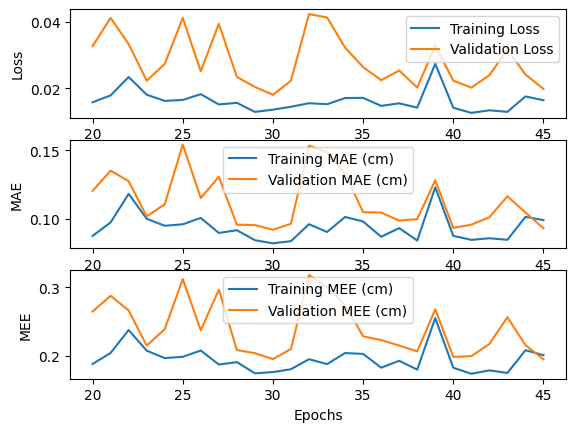

In [38]:
plot_metrics(
    history, start_epoch=20, end_epoch=None,
    metrics=['loss', 'mean_absolute_error', 'mean_euclidean_error'],
    data_labels=[
        ('Training Loss', 'Validation Loss'), ('Training MAE (cm)', 'Validation MAE (cm)'),
        ('Training MEE (cm)', 'Validation MEE (cm)')
    ],
    axes_labels=[
        ('Epochs', 'Loss'), ('Epochs', 'MAE'), ('Epochs', 'MEE')
    ]
)

 1/33 [..............................] - ETA: 6s

/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1176: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)


33/33 [==============================] - 1s 22ms/step
1030 1030 1030
1030 1030 1030
x-axis: mean = 0.5058719514968468, std = 2.568764182943583
y-axis: mean = 0.1453649984300966, std = 0.3883222532729143
z-axis: mean = 0.03848501678112411, std = 0.051770306291136665


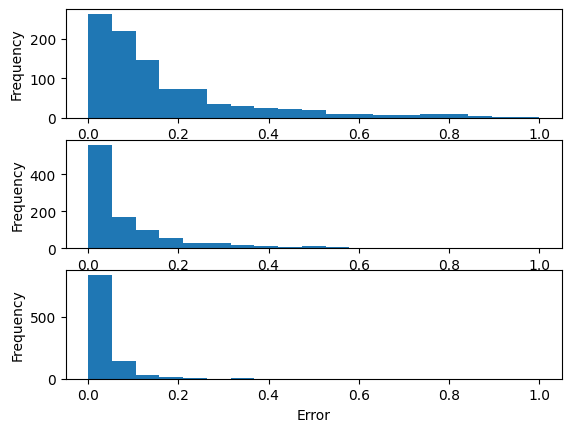

In [39]:
epsilon = 1e-12
predictions = model.predict(eval_images)
plot_relative_errors(predictions, eval_tip_pos, epsilon, max_error=1, nbins=20)

...

We now calculate also mean and standard deviation of loss, absolute and euclidean errors:

In [40]:
mean_absolute_errors = tf.keras.metrics.mean_absolute_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MAE: {np.mean(mean_absolute_errors)}')
print(f'Std of MAE: {np.std(mean_absolute_errors)}')

mean_euclidean_errors = mean_euclidean_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MEE: {np.mean(mean_euclidean_errors)}')
print(f'Std of MEE: {np.std(mean_euclidean_errors)}')

Mean of MAE: 0.09227590262889862
Std of MAE: 0.05749319866299629
Mean of MEE: 0.1935628456253955
Std of MEE: 0.14194343259436212


We calculate them also along each axis:

In [41]:
distances = np.abs(eval_tip_pos - predictions)
print(f'Mean Distance along axes: {np.mean(distances, axis=0)}')
print(f'Std of Distance along axes: {np.std(distances, axis=0)}')

Mean Distance along axes: [0.14467846 0.06866742 0.06348184]
Std of Distance along axes: [0.15091634 0.05163246 0.04995844]


In [42]:
del model

#### $1\cdot10^{-4}$ learning rate

In [45]:
train_mean, train_std = np.mean(train_tip_pos), np.mean(eval_tip_pos)
train_tip_pos_bak = train_tip_pos.copy()
train_tip_pos = (train_tip_pos - train_mean) / train_std
eval_tip_pos = (eval_tip_pos - train_mean) / (train_std)

In [46]:
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
)
base_model.trainable = False

In [47]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = data_augmenter(inputs, training=False)
x = base_model(x, training=False)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(3, activation='linear')(x)
model = tf.keras.Model(inputs, outputs)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1176: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)


In [48]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 3)                 75267     
                                                                 
Total params: 14,789,955
Trainable params: 75,267
Non-trainable params: 14,714,688
_________________________________________________________________


In [49]:
model.compile(
    loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    metrics=['mean_absolute_error', mean_euclidean_error]
)

In [50]:
history = model.fit(
    train_images, train_tip_pos, epochs=n_epochs,
    validation_data=(eval_images, eval_tip_pos),
    batch_size = batch_size, shuffle=True,
    callbacks=[tf.keras.callbacks.EarlyStopping(min_delta=0, patience=15)]
)

Epoch 1/100
96/96 [==============================] - 5s 40ms/step - loss: 0.3885 - mean_absolute_error: 0.4143 - mean_euclidean_error: 0.8467 - val_loss: 0.1098 - val_mean_absolute_error: 0.2269 - val_mean_euclidean_error: 0.4843
Epoch 2/100
96/96 [==============================] - 3s 33ms/step - loss: 0.0703 - mean_absolute_error: 0.1777 - mean_euclidean_error: 0.3859 - val_loss: 0.0683 - val_mean_absolute_error: 0.1722 - val_mean_euclidean_error: 0.3733
Epoch 3/100
96/96 [==============================] - 3s 32ms/step - loss: 0.0507 - mean_absolute_error: 0.1461 - mean_euclidean_error: 0.3238 - val_loss: 0.0563 - val_mean_absolute_error: 0.1539 - val_mean_euclidean_error: 0.3360
Epoch 4/100
96/96 [==============================] - 3s 32ms/step - loss: 0.0375 - mean_absolute_error: 0.1278 - mean_euclidean_error: 0.2825 - val_loss: 0.0444 - val_mean_absolute_error: 0.1420 - val_mean_euclidean_error: 0.3097
Epoch 5/100
96/96 [==============================] - 3s 32ms/step - loss: 0.0345

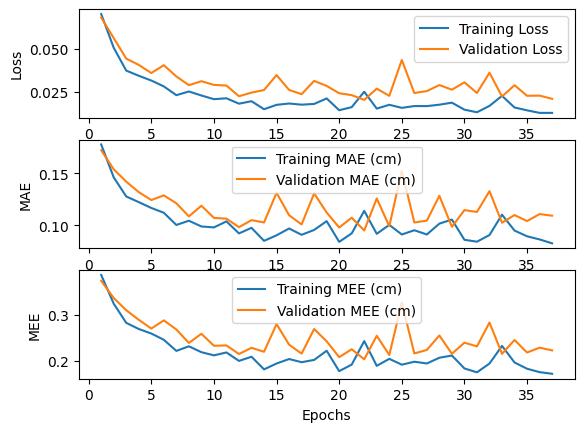

In [58]:
plot_metrics(
    history, start_epoch=1, end_epoch=None,
    metrics=['loss', 'mean_absolute_error', 'mean_euclidean_error'],
    data_labels=[
        ('Training Loss', 'Validation Loss'), ('Training MAE (cm)', 'Validation MAE (cm)'),
        ('Training MEE (cm)', 'Validation MEE (cm)')
    ],
    axes_labels=[
        ('Epochs', 'Loss'), ('Epochs', 'MAE'), ('Epochs', 'MEE')
    ]
)

33/33 [==============================] - 1s 21ms/step
1030 1030 1030
1030 1030 1030
x-axis: mean = 0.48895171060405895, std = 1.8608754427828695
y-axis: mean = 0.1394544888604007, std = 0.3885446214958313
z-axis: mean = 0.06672731159490161, std = 0.05254668077467972


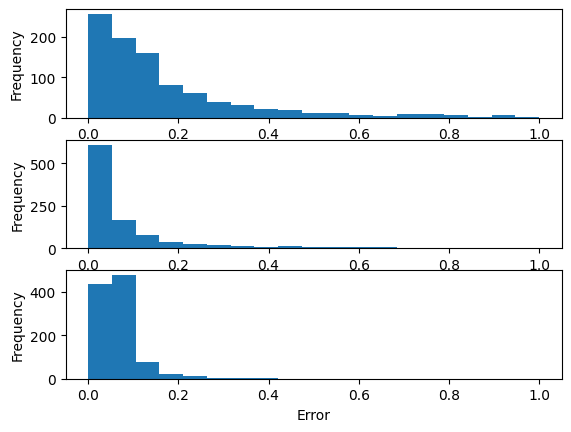

In [52]:
epsilon = 1e-12
predictions = model.predict(eval_images)
plot_relative_errors(predictions, eval_tip_pos, epsilon, max_error=1, nbins=20)

...

We now calculate also mean and standard deviation of loss, absolute and euclidean errors:

In [53]:
mean_absolute_errors = tf.keras.metrics.mean_absolute_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MAE: {np.mean(mean_absolute_errors)}')
print(f'Std of MAE: {np.std(mean_absolute_errors)}')

mean_euclidean_errors = mean_euclidean_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MEE: {np.mean(mean_euclidean_errors)}')
print(f'Std of MEE: {np.std(mean_euclidean_errors)}')

Mean of MAE: 0.11048039048910141
Std of MAE: 0.06728311628103256
Mean of MEE: 0.22638566021557027
Std of MEE: 0.16017479672132115


We calculate them also along each axis:

In [54]:
distances = np.abs(eval_tip_pos - predictions)
print(f'Mean Distance along axes: {np.mean(distances, axis=0)}')
print(f'Std of Distance along axes: {np.std(distances, axis=0)}')

Mean Distance along axes: [0.15541315 0.06142029 0.11460773]
Std of Distance along axes: [0.17300097 0.05222561 0.05647082]


In [55]:
del model